In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import pandas as pd
import numpy as np
import torch
import gc
import torch.nn as nn
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import random
from sklearn import tree
from sklearn.model_selection import cross_val_score
from pymop import Problem
import os
from tslearn.datasets import UCR_UEA_datasets
import warnings
warnings.filterwarnings('ignore')
import pickle
import sklearn

In [2]:
dataset='GunPoint'
X_train,train_y,X_test,test_y=UCR_UEA_datasets().load_dataset(dataset)
train_x=np.swapaxes(X_train,1,2)#.reshape(-1,X_train.shape[-1],X_train.shape[-2])
test_x=np.swapaxes(X_test,1,2)#.reshape(-1,X_train.shape[-1],X_train.shape[-2])
#enc1=pickle.load(open(f'../../ClassificationModels//models/{dataset}/OneHotEncoder.pkl','rb'))
enc1=sklearn.preprocessing.OneHotEncoder(sparse=False).fit(np.vstack((train_y.reshape(-1,1),test_y.reshape(-1,1))))
test_y=enc1.transform(test_y.reshape(-1,1))
train_y=enc1.transform(train_y.reshape(-1,1))
n_classes = test_y.shape[1]


In [13]:
from ClassificationModels.CNN_T import ResNetBaseline, UCRDataset, get_all_preds, fit
stride = 1
kernel_size=10
padding = kernel_size - 1
input_size= train_x.shape[-1]
device = torch.device( "cuda:0" if torch.cuda.is_available() else "cpu")#"cuda:0" if torch.cuda.is_available() else
model = ResNetBaseline(in_channels= 1, num_pred_classes=n_classes)
train_dataset = UCRDataset(train_x.astype(np.float64),train_y.astype(np.int64))
test_dataset = UCRDataset(test_x.astype(np.float64),test_y.astype(np.int64))
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=16,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=1,shuffle=False)
fit(model, train_loader, test_loader,num_epochs=100)
#model.load_state_dict(torch.load(f'../../ClassificationModels/models/{dataset}/ResNet'))
torch.save(model.state_dict(), f'ClassificationModels/{dataset}_ResNet')
test_dataset = UCRDataset(test_x,test_y)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=1,shuffle=False)


Epoch: 1, Train loss: 0.718, Val loss: 0.699
Epoch: 2, Train loss: 0.71, Val loss: 0.693
Epoch: 3, Train loss: 0.709, Val loss: 0.704
Epoch: 4, Train loss: 0.725, Val loss: 0.692
Epoch: 5, Train loss: 0.685, Val loss: 0.689
Epoch: 6, Train loss: 0.678, Val loss: 0.688
Epoch: 7, Train loss: 0.699, Val loss: 0.686
Epoch: 8, Train loss: 0.683, Val loss: 0.68
Epoch: 9, Train loss: 0.708, Val loss: 0.693
Epoch: 10, Train loss: 0.685, Val loss: 0.682
Epoch: 11, Train loss: 0.669, Val loss: 0.669
Epoch: 12, Train loss: 0.68, Val loss: 0.672
Epoch: 13, Train loss: 0.66, Val loss: 0.668
Epoch: 14, Train loss: 0.653, Val loss: 0.69
Epoch: 15, Train loss: 0.731, Val loss: 0.68
Epoch: 16, Train loss: 0.626, Val loss: 0.655
Epoch: 17, Train loss: 0.631, Val loss: 0.654
Epoch: 18, Train loss: 0.649, Val loss: 0.67
Epoch: 19, Train loss: 0.643, Val loss: 0.692
Epoch: 20, Train loss: 0.652, Val loss: 0.67
Epoch: 21, Train loss: 0.643, Val loss: 0.653
Epoch: 22, Train loss: 0.61, Val loss: 0.619
Epoch:

In [14]:
model.eval()
y_pred,labels= get_all_preds(model,test_loader)
print(y_pred)

[0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]


In [15]:
observation_01, label_01 = test_dataset[0]
label_01=np.array([y_pred[0]])
print(observation_01.shape)
print(label_01.shape)


(1, 150)
(1,)


In [16]:
from TSInterpret.InterpretabilityModels.counterfactual.TSEvoCF import TSEvo
exp =TSEvo(model= model,data=(test_x,np.array(y_pred)), mode = 'feat',backend='PYT',epochs =500)

In [17]:
pop,label_cf=exp.explain(observation_01.reshape(1,1,-1),np.array(label_01))

No Target


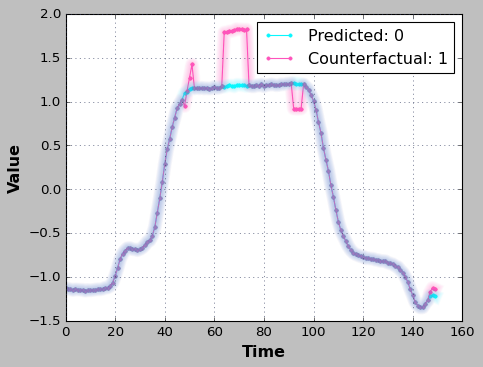

In [18]:
exp.plot_in_one(observation_01,label_01[0],pop,np.argmax(label_cf),save_fig=None)

In [ ]:
exp_second